<a href="https://colab.research.google.com/github/aguschanchu/FermionicML/blob/main/FermionicML.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# FermionicML:

Code based on aguschanchu/Bosonic.py

## Código base

Cargamos el código de Bosonic.py básico, branch fermionic

In [34]:
import numpy as np
from scipy.special import binom
from scipy.sparse import dok_matrix, linalg
from scipy import linalg as linalg_d
from joblib import Memory
import random
import plotly.graph_objects as go
from joblib import Parallel, delayed
from numba import jit, prange, njit
import numba as nb
import pickle
import math

# Funciones auxiliares optimiadas
@nb.jit(nopython=True, parallel=True)
def int_to_tuple_arr(ni,nf, b, digits=None):
    sol = np.zeros((nf-ni, digits), dtype=np.int64)
    for n in prange(ni, nf):
        r = np.zeros(digits, dtype=np.int64)
        ncop = n
        idx = 0
        while n != 0:
            r[idx] = n % b
            n = n // b
            idx += 1
        if digits is not None:
            if idx < digits:
                for i in range(idx, digits):
                    r[i] = 0
                idx = digits
        sol[ncop-ni,:] = r[:idx]
    return sol

def tuple_to_int(t, d):
    b = d-1
    l = len(t)
    s = [t[k]*b**(l-k-1) for k in range(0,l)]
    return sum(s)

def create_basis_(m, d, size):
    base = []
    index = 0
    chunk_size = 1000000
    for x in range(0,(m+1)**d, chunk_size):
        start_index = x
        end_index = min(x + chunk_size, (m+1)**d)
        arr = int_to_tuple_arr(start_index, end_index, m+1, d)
        sums = np.sum(arr, axis=1)
        rows = np.where(sums == m)[0]
        for row in [arr[i] for i in rows]:
            if np.all(np.logical_or(row == 0, row == 1)):
                base.append(row)

    # Como consecuencia de la paralelizacion, es necesario reordenar la base
    sorted_base = sorted(base, key=lambda x: tuple_to_int(x, d), reverse=True)
    assert len(base) == size

    return base

class fixed_basis:

    # Convierte a un enterno n a su escritura en base b
    def _int_to_tuple(self, n, b, digits = None):
        rep = np.base_repr(n, b)
        rep_int = [int(x,b) for x in rep]
        if digits is not None:
            zeros = [0 for i in range(0,digits-len(rep))]
            return zeros + rep_int
        else:
            return rep_int

    # Revierte la transformacion anterior
    def tuple_to_int(self, t):
        b = self.d-1
        l = len(t)
        s = [t[k]*b**(l-k-1) for k in range(0,l)]
        return sum(s)

    # Convierte el vector en su representacion
    def vect_to_repr(self, vect):
        for i, k in enumerate(vect):
            if k == 1. or k == 1:
                break
        else:
            return 0
        return self.base[i,:]

    def rep_to_vect(self, rep):
        rep = list(rep)
        for i, r in [(j, self.base[j,:]) for j in range(0,self.size)]:
            if list(r) == rep:
                return self.canonicals[:,i]
        else:
            None

    def rep_to_index(self, rep):
        return self.base.tolist().index(list(rep))

    @staticmethod
    def rep_to_exi(rep):
        r = []
        for i, k in enumerate(rep):
            r += [i for x in range(0,k)]
        return r

    # Crea base de M particulas en D estados (repr y base canonica)
    def create_basis(self, m, d):
        #print("Creating basis: ", m, d)
        length = int(binom(d,m))
        base = np.array(create_basis_(m, d, length))
        # Asignamos a cada uno de ellos un canónico
        canonicals = np.eye(length)
        return base, canonicals

    def __init__(self, m, d):
        self.m = m
        self.d = d
        self.size = int(binom(d,m))
        (self.base, self.canonicals) = self.create_basis(m, d)

# Matrices de aniquilación y creación endomórficas. Estan fuera de la clase para poder ser cacheadas
#@memory.cache
def bdb(basis, i, j):
    mat = dok_matrix((basis.size, basis.size), dtype=np.float32)
    if i != j:
        for k, v in enumerate(basis.base):
            if v[j] != 0 and v[i] != 1:
                print(v)
                dest = list(v.copy())
                dest[j] -= 1
                dest[i] += 1
                tar = basis.rep_to_index(dest)
                mat[tar, k] = np.sqrt(v[i]+1)*np.sqrt(v[j])
    else:
        for k, v in enumerate(basis.base):
            if v[j] != 0:
                mat[k, k] = v[i]
    return mat

#@memory.cache
def bbd(basis, i, j):
    mat = dok_matrix((basis.size, basis.size), dtype=np.float32)
    if i != j:
        for k, v in enumerate(basis.base):
            if v[i] != 0 and v[j] != 1:
                dest = list(v.copy())
                dest[i] -= 1
                dest[j] += 1
                tar = basis.rep_to_index(dest)
                mat[tar, k] = np.sqrt(v[j]+1)*np.sqrt(v[i])
    else:
        for k, v in enumerate(basis.base):
            if v[i] != 1:
                mat[k, k] = v[i]+1
    return mat

# Matrices de aniquilación y creación.Toman la base de origen y destino (basis_o, basis_d) resp
#@nb.jit(nopython=True, parallel=True)
@nb.jit(nopython=True)
def b_aux(basis_o, basis_d, i):
    mat = np.zeros((len(basis_d), len(basis_o)), dtype=np.float32)
    for k in prange(len(basis_o)):
        if basis_o[k][i] != 0:
            dest = list(basis_o[k].copy())
            dest[i] -= 1
            for j in prange(len(basis_d)):
                if list(basis_d[j]) == dest:
                    tar = j
                    mat[tar, k] = np.sqrt(basis_o[k][i])
    return mat

def b(basis_o, basis_d, i):
    return b_aux(basis_o.base, basis_d.base, i)

#@nb.jit(nopython=True, parallel=True)
@nb.jit(nopython=True)
def bd_aux(basis_o, basis_d, i):
    mat = np.zeros((len(basis_d), len(basis_o)), dtype=np.float32)
    for k in prange(len(basis_o)):
        if basis_o[k][i] != 1:
            dest = list(basis_o[k].copy())
            dest[i] += 1
            for j in prange(len(basis_d)):
                if list(basis_d[j]) == dest:
                    tar = j
                    mat[tar, k] = np.sqrt(basis_o[k][i]+1)
    return mat

def bd(basis_o, basis_d, i):
    return bd_aux(basis_o.base, basis_d.base, i)

# Acepta una lista de indices a crear
@nb.jit(nopython=True, parallel=True)
def bd_gen_aux(basis_o, basis_d, gen_list:list):
    mat = np.zeros((len(basis_d), len(basis_o)), dtype=np.float32)
    for k in prange(len(basis_o)):
        conds = np.zeros(len(gen_list), dtype=np.int64)
        for i in range(len(gen_list)):
            if basis_o[k][gen_list[i]] != 1:
                conds[i] = 1
        if np.all(conds):
            dest = list(basis_o[k].copy())
            for i in gen_list:
                dest[i] += 1
            for j in prange(len(basis_d)):
                if list(basis_d[j]) == dest:
                    tar = j
                    mat[tar, k] = np.sqrt(basis_o[k][i]+1)
    return mat

def bd_gen(basis_o, basis_d, i):
    return bd_gen_aux(basis_o.base, basis_d.base, np.array(i))

def b_gen(basis_o, basis_d, i):
    return np.transpose(bd_gen(basis_d, basis_o, i))

# Volvemos a definir la función para compilarla
@nb.jit(forceobj=True)
def _rep_to_index(base, rep):
    return base.tolist().index(list(rep))

# Funciones auxiliares para calcular rho2kkbar y gamma_p
@nb.jit(nopython=True)
def rep_to_exi(rep):
    r = []
    for i in range(len(rep)):
        for j in range(rep[i]):
            r.append(i)
    return r

@nb.njit
def factorial(n):
    result = 1
    for i in range(1, n + 1):
        result *= i
    return result

@nb.njit
def gamma_lamba(x):
    res = 1.0
    for o in x:
        res *= math.sqrt(factorial(o))
    return res

@nb.jit
def gamma_lamba_inv(x):
    res = 1.0
    for o in x:
        res *= 1.0 / np.sqrt(factorial(o))
    return res

@nb.njit
def rep_to_index_np(base, rep):
    for i in range(len(base)):
        if np.all(base[i] == rep):
            return i
    return -1


def gamma_p(basis, m, vect, m_basis = None, nm_basis = None):
    d = basis.d
    if not m_basis or not nm_basis:
        m_basis = fixed_basis(m, d)
        nm_basis = fixed_basis(basis.m-m,d)
    return gamma_p_aux(basis.base, vect, m_basis.base, nm_basis.base)

@nb.njit()
def gamma_p_aux(basis, vect, m_basis, nm_basis):
    mat = np.zeros((len(m_basis), len(nm_basis)), dtype=np.float32)
    for i in prange(len(m_basis)):
        v = m_basis[i]
        for j in prange(len(nm_basis)):
            w = nm_basis[j]
            targ = v + w
            index = rep_to_index_np(basis, targ)
            if index != -1:
                coef = vect[index]
                if coef != 0:
                    coef = coef * gamma_lamba_inv(v) * gamma_lamba_inv(w) * gamma_lamba(targ)
                mat[i, j] = coef
    return mat
# Devuelve la matriz rho M asociada al vector
def rho_m(basis, m, vect, m_basis = None, nm_basis = None):
    g = gamma_p(basis, m, vect, m_basis, nm_basis)
    return np.dot(g,np.transpose(g))

# Devuelve la matriz gamma asociada a la descomposición (M,N-M) del vector
@jit(forceobj=True)
def gamma(basis, m, vect, m_basis = None, nm_basis = None):
    d = basis.d
    if not m_basis or not nm_basis:
        m_basis = fixed_basis(m, d)
        nm_basis = fixed_basis(basis.m-m,d)
    mat = dok_matrix((m_basis.size, nm_basis.size), dtype=np.float32)
    for i, v in enumerate(m_basis.base):
        for j, w in enumerate(nm_basis.base):
            targ = v+w
            # Revisamos que sea un estado fermionico valido
            arr = np.asarray(targ)
            if not np.all(np.logical_or(arr == 0, arr == 1)):
                continue
            index = _rep_to_index(basis.base, targ)
            coef = vect[index]
            if coef != 0:
                aux = lambda x: np.prod(np.reciprocal(np.sqrt([np.math.factorial(o) for o in x])))
                aux_inv = lambda x: np.prod(np.sqrt([np.math.factorial(o) for o in x]))
                coef = coef * aux(v) * aux(w) * aux_inv(targ)
                #coef = coef
                #print(v,w,coef)
            mat[i,j] = coef
    return mat

# Devuelve la matriz rho 1 asociada al vector
def rho_1(basis, vect):
    d = basis.d
    mat = dok_matrix((d, d), dtype=np.float32)
    for i in range(0, d):
        for j in range(0, d):
            v = bdb(basis,j,i)*vect
            mat[i,j] = np.inner(vect,v)
    return mat

# Devuelve la matriz rho 2 asociada al vector
def rho_2(basis, vect, ml_basis = None, mll_basis = None, t_basis = None):
    d = basis.d
    # Creo las bases si no están dadad
    if ml_basis == None or mll_basis == None or t_basis == None:
        ml_basis = fixed_basis(m-1,d)
        mll_basis = fixed_basis(m-2,d)
        t_basis = fixed_basis(2,d)
    mat = dok_matrix((t_basis.size, t_basis.size), dtype=np.float32)
    for i, v in enumerate(t_basis.base):
        for j, w in enumerate(t_basis.base):
            # Creacion de los a
            i_set = t_basis.rep_to_exi(v)
            b_m = np.dot(b(ml_basis, mll_basis, i_set[1]),b(basis, ml_basis, i_set[0]))

            # Creacion de los ad
            i_set = t_basis.rep_to_exi(w)
            bd_m = np.dot(bd(ml_basis, basis, i_set[1]),bd(mll_basis, ml_basis, i_set[0]))

            # Mult de b's y filleo de mat
            coef = np.inner(vect,np.dot(bd_m,b_m)*vect)
            aux = lambda x: np.prod(np.reciprocal(np.sqrt([np.math.factorial(o) for o in x])))
            mat[i,j] = coef * aux(v) * aux(w)
    return mat

# Devuelve la matriz rho 2 asociada al bloque kkbar
def rho_2_kkbar(basis, vect, ml_basis = None, mll_basis = None, t_basis = None):
    d = basis.d
    # Creo las bases si no están dadas
    if ml_basis == None or mll_basis == None or t_basis == None:
        ml_basis = fixed_basis(m-1,d)
        mll_basis = fixed_basis(m-2,d)
        t_basis = fixed_basis(2,d)
    diag = []
    for v in t_basis.base:
        for j in range(0, d, 2):
            if v[j] == v[j+1]:
                continue
            else:
                break
        else:
            diag.append(v)
    diag = np.array(diag)
    return rho_2_kkbar_aux(diag, vect, basis.base, ml_basis.base, mll_basis.base, t_basis.base)

@nb.njit
def rho_2_kkbar_lambda(x):
    res = 1.0
    for o in x:
        res *= 1.0 / math.sqrt(factorial(o))
    return res

@nb.njit(parallel=True)
def rho_2_kkbar_aux(diag, vect, basis, ml_basis, mll_basis, t_basis):
    mat = np.zeros((len(diag), len(diag)), dtype=np.float32)
    for i in prange(len(diag)):
        for j in prange(len(diag)):
            v = diag[i]
            w = diag[j]
            # Creacion de los a
            i_set = rep_to_exi(v)
            b_m = b_aux(ml_basis, mll_basis, i_set[1]) @ b_aux(basis, ml_basis, i_set[0])
            # Creacion de los ad
            i_set = rep_to_exi(w)
            bd_m = bd_aux(ml_basis, basis, i_set[1]) @ bd_aux(mll_basis, ml_basis, i_set[0])
            v1 = bd_m @ b_m @ vect
            # Mult de b's y filleo de mat
            coef = vect @ v1
            rho_2_kkbar_lambda(v)
            mat[i,j] = coef * rho_2_kkbar_lambda(v) * rho_2_kkbar_lambda(w)
    return mat

## Definicion de Hamiltoniano

Cargamos el código de creación y resolución de Hamiltonianos

In [35]:
m = 2
d = 4
# Creo las bases para no tener que recrearlas luego
basis = fixed_basis(m, d)
basis_m1 = fixed_basis(m-1, d)
basis_m2 = fixed_basis(m-2, d)
print(basis.base)
print(basis.size)

[[1 1 0 0]
 [1 0 1 0]
 [0 1 1 0]
 [1 0 0 1]
 [0 1 0 1]
 [0 0 1 1]]
6


In [113]:
# Dados 1/2 (d^2+d) elementos, genera una mat de dxd:
def sym_mat_gen(vect, d):
    matrix = np.zeros((d, d))
    idx = 0
    for i in range(d):
        for j in range(i, d):
            matrix[i, j] = vect[idx]
            idx += 1
    return matrix + matrix.T - np.diag(matrix.diagonal())

# Dada un a mat dxd simetrica, contruye el hamiltoniano de un cuerpo a_{ij} c^{dag}_i c_j
@njit(nopython=True, parallel=True)
def base_hamiltonian_aux(mat, basis, size, d, basis_m1, basis_m2):
    # Construccion de H
    h = np.zeros((size,size), dtype=np.float32)
    for i in prange(0, d):
        for j in prange(0, d):
            h += mat[i,j] * np.dot(bd_aux(basis_m1, basis,i), b_aux(basis, basis_m1, j))
    return h

def base_hamiltonian(mat, basis, basis_m1, basis_m2):
    return base_hamiltonian_aux(mat, basis.base, basis.size, basis.d, basis_m1.base, basis_m2.base)

def solve(h, last_step = None):
    sol = linalg.eigsh(h, which='SA',k=19)
    eigenspace_tol = 0.0001
    if type(last_step) != type(None):
        # Seleccionamos todos los autovects que difieren sus autovalores menos que tol (mismo autoespacio)
        # y tomamos la proyección en el autoespacio de la solución del paso anterior (last_step)
        eig = sol[0].real
        eigv = sol[1]
        cand = [eigv[:,i].real  for (i, x) in enumerate(eig) if abs(x-min(eig)) < eigenspace_tol]
        cand_norm = [x/np.linalg.norm(x) for x in cand]
        fund = np.zeros(len(cand[0]))
        for x in cand_norm:
            fund += np.dot(last_step,x) * x
    else:
        argmin = np.argmin(sol[0].real)
        fund = sol[1][:,argmin]
    fund = fund.real / np.linalg.norm(fund)
    return fund

/usr/local/lib/python3.10/dist-packages/numba/core/decorators.py:253: RuntimeWarning: nopython is set for njit and is ignored
  warnings.warn('nopython is set for njit and is ignored', RuntimeWarning)


## Modelo de ML
Basado en matrices densidad de 1 y 2 cuerpos como input, con hamiltoniano como salida

In [37]:
import tensorflow as tf
import numpy as np

In [38]:
# Construccion de bases para calculo de rho1 y rho2
# rho2
m = 2
m2_basis = fixed_basis(m, d)
print(m2_basis.size)
nm2_basis = fixed_basis(basis.m-m, d)
# rho1
m = 1
m1_basis = fixed_basis(m, d)
print(m1_basis.size)
nm1_basis = fixed_basis(basis.m-m, d)

6
4


### Algunos benchmarks y funciones auxiliares

In [39]:
import time
t0 = time.time()
a = bd_aux(basis_m1.base, basis.base, 1)
b = b_aux(basis.base, basis_m1.base, 2)
print(time.time()-t0)
t0 = time.time()
np.dot(a,b)
print(time.time() - t0)


0.6512072086334229
0.0002739429473876953


In [40]:
# Given h calculo en rho2 y rho1 máximo
def rho1_rho2(h):
    fund = solve(h)
    rho2 = rho_m(basis, 2, fund, m2_basis, nm2_basis)
    r = np.sort(linalg_d.eigvals(rho2).real)
    rho_2_max = r[0]
    rho1 = rho_m(basis, 1, fund, m1_basis, nm1_basis)
    r = np.sort(linalg_d.eigvals(rho1).real)
    rho_1_max = r[0]

    return (rho_1_max, rho_2_max)


### Construccion de dataset

In [117]:
import time
from tqdm import tqdm
# Construccion de listas de dataset
num_samples = 50000
rho_1_input = []
rho_2_input = []
fund_input = []
h_labels = []

t0 = time.time()
for i in tqdm(range(num_samples)):
    mat_size = (basis.size**2+basis.size)//2
    base_vect = np.random.rand(mat_size)
    hamil_base = sym_mat_gen(base_vect, basis.size)
    # Calculamos el fundamental
    h = base_hamiltonian(hamil_base, basis, basis_m1, basis_m2)
    # Guardamos el label
    h_labels.append(h.flatten())
    fund = solve(h)
    fund_input.append(fund)
    # Calculamos las matrices de 1 y 2 cuerpos
    rho2 = rho_m(basis, 2, fund, m2_basis, nm2_basis)
    rho_2_input.append(rho2)
    rho1 = rho_m(basis, 1, fund, m1_basis, nm1_basis)
    rho_1_input.append(rho1)

print(time.time()-t0)
dataset = tf.data.Dataset.from_tensor_slices(((rho_1_input, rho_2_input), h_labels))

rho1_size = m1_basis.size
rho2_size = m2_basis.size
fund_size = basis.size
#batch_size = 32
#dataset = dataset.shuffle(buffer_size=num_samples).batch(batch_size)

  0%|          | 0/50000 [00:00<?, ?it/s]/usr/local/lib/python3.10/dist-packages/scipy/sparse/linalg/_eigen/arpack/arpack.py:1600: RuntimeWarning: k >= N for N * N square matrix. Attempting to use scipy.linalg.eigh instead.
  warnings.warn("k >= N for N * N square matrix. "
100%|██████████| 50000/50000 [01:03<00:00, 781.63it/s]


63.97659873962402


In [118]:

# Dividimos los datasets
train_size = int(0.8 * num_samples)

train_dataset = dataset.take(train_size)
val_dataset = dataset.skip(train_size)


batch_size = 1024
train_dataset = train_dataset.shuffle(buffer_size=num_samples).batch(batch_size)
val_dataset = val_dataset.shuffle(buffer_size=num_samples).batch(batch_size)

### Definición de modelo

In [145]:
from keras.layers.attention.multi_head_attention import activation
# Definicion de layers

## rho 1
rho1_layer =  tf.keras.layers.Input(shape=(rho1_size,rho1_size) + (1,), name='rho1')

# Procesamos el primer input
conv_rho1 = tf.keras.layers.Conv2D(16, (3, 3), activation='relu')(rho1_layer)
#pool_rho1 = tf.keras.layers.MaxPooling2D((2, 2))(conv_rho1)

flatten_rho1 = tf.keras.layers.Flatten()(conv_rho1)

## rho 2
rho2_layer =  tf.keras.layers.Input(shape=(rho2_size,rho2_size) + (1,), name='rho2')

# Procesamos el segundo input
conv_rho2 = tf.keras.layers.Conv2D(16, (3, 3), activation='relu')(rho2_layer)
#pool_rho2 = tf.keras.layers.MaxPooling2D((2, 2))(conv_rho2)

flatten_rho2 = tf.keras.layers.Flatten()(conv_rho2)

## fund (deprecated)
fund_layer =  tf.keras.layers.Input(shape=(fund_size,), name='fund')
flatten_fund = tf.keras.layers.Flatten()(fund_layer)

# Concatenamos y construimos el resto de la arquitectura del modelo
concatenated = tf.keras.layers.concatenate([flatten_rho1, flatten_rho2])

local_size = basis.size*basis.size
dense1 = tf.keras.layers.Dense(local_size*2, activation='relu')(concatenated)
output = tf.keras.layers.Dense(local_size)(dense1)


# Creamos el modelo y compulamos
model = tf.keras.models.Model(inputs=[rho1_layer, rho2_layer], outputs=output)
model.summary()

Model: "model_5"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 rho1 (InputLayer)              [(None, 4, 4, 1)]    0           []                               
                                                                                                  
 rho2 (InputLayer)              [(None, 6, 6, 1)]    0           []                               
                                                                                                  
 conv2d_10 (Conv2D)             (None, 2, 2, 16)     160         ['rho1[0][0]']                   
                                                                                                  
 conv2d_11 (Conv2D)             (None, 4, 4, 16)     160         ['rho2[0][0]']                   
                                                                                            

In [146]:
r_size = basis.size

# Custom loss function based on GS MSE
def gs_loss(h_pred, h_true):
    h_pred = tf.reshape(h_pred, shape=(-1,r_size,r_size))
    e, v = tf.linalg.eigh(h_pred)
    gs_pred = v[:, 0]

    h_true = tf.reshape(h_true, shape=(-1,r_size,r_size))
    e, v = tf.linalg.eigh(h_true)
    gs_true = v[:, 0]

    gs_diff = tf.norm(gs_true - gs_pred)

    return gs_diff

def distance_to_hermitian(matrix):
    hermitian_part = 0.5 * (matrix + tf.linalg.adjoint(matrix))
    distance = tf.norm(matrix - hermitian_part, ord='euclidean')
    return distance

# Custom loss function based on MSE + non-hermitian penalization
def herm_loss(h_pred, h_true):
    h_pred_arr = tf.reshape(h_pred, shape=(-1,r_size,r_size))
    return tf.reduce_mean(tf.square(h_true - h_pred)) + distance_to_hermitian(h_pred_arr)

In [147]:
from tensorflow.keras.optimizers import RMSprop, Adam, Nadam

# Compile the model
model.compile(optimizer=Nadam(),
              loss='MSE',  # Use appropriate loss for your task
              metrics=['accuracy', 'mean_squared_error'])

# Train the model
num_epochs = 10
history = model.fit(train_dataset, epochs=num_epochs, batch_size=1024, validation_data=val_dataset)

Epoch 1/10
40/40 [==============================] - 5s 37ms/step - loss: 0.2178 - accuracy: 0.1418 - mean_squared_error: 0.2178 - val_loss: 0.0756 - val_accuracy: 0.2345 - val_mean_squared_error: 0.0756
Epoch 2/10
40/40 [==============================] - 1s 25ms/step - loss: 0.0688 - accuracy: 0.3185 - mean_squared_error: 0.0688 - val_loss: 0.0649 - val_accuracy: 0.4148 - val_mean_squared_error: 0.0649
Epoch 3/10
40/40 [==============================] - 1s 26ms/step - loss: 0.0623 - accuracy: 0.4875 - mean_squared_error: 0.0623 - val_loss: 0.0610 - val_accuracy: 0.5470 - val_mean_squared_error: 0.0610
Epoch 4/10
40/40 [==============================] - 1s 26ms/step - loss: 0.0591 - accuracy: 0.5704 - mean_squared_error: 0.0591 - val_loss: 0.0582 - val_accuracy: 0.5860 - val_mean_squared_error: 0.0582
Epoch 5/10
40/40 [==============================] - 1s 26ms/step - loss: 0.0564 - accuracy: 0.5937 - mean_squared_error: 0.0564 - val_loss: 0.0556 - val_accuracy: 0.5943 - val_mean_squared

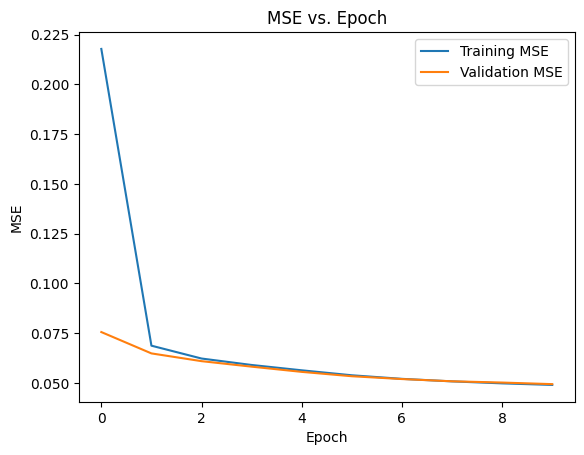

In [148]:
import matplotlib.pyplot as plt
#plt.plot(history.history['accuracy'], label='Training Accuracy')
#plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.plot(history.history['mean_squared_error'], label='Training MSE')
plt.plot(history.history['val_mean_squared_error'], label='Validation MSE')

plt.xlabel('Epoch')
plt.ylabel('MSE')
plt.title('MSE vs. Epoch')
plt.legend()
plt.show()

# MIN LOSS = 0.06

In [149]:
# Assuming you have a validation dataset (val_dataset)
sample = next(iter(val_dataset))
input_data = sample[0]  # Assuming your dataset provides input data as the first element
actual_values = sample[1]  # Assuming your dataset provides actual labels as the second element

# Predict using the model
predictions = model.predict(input_data)

32/32 [==============================] - 0s 2ms/step


In [151]:
#Compare predicted and actual values
f = 100
m_size = basis.size
for i in range(4,5):
    print(i)
    print("PREDICTED")
    mat = predictions[i]
    h = mat.reshape(m_size, m_size)
    print(mat)
    # h = base_hamiltonian(hamil_base, basis, basis_m1, basis_m2)
    fund = solve(h)
    print(fund)
    (rho_1, rho_2) = rho1_rho2(h)
    #print(h)
    print(f"Rho1 {rho_1*f}, Rho2 {rho_2*f}")
    print("ACTUAL VALUE")
    mat = actual_values[i]
    print(mat)
    h = mat.numpy().reshape(m_size, m_size)
    # h = base_hamiltonian(hamil_base, basis, basis_m1, basis_m2)
    fund = solve(h)
    print(fund)
    (rho_1, rho_2) = rho1_rho2(h)
    #print(h)
    print(f"Actual value {rho_1*f}, {rho_2*f}")
    #print(f"Sample {i + 1} - Predicted: {predictions[i]}, Actual: {actual_values[i]}")

4
PREDICTED
[ 1.4321259e+00  5.6717288e-01  6.5469348e-01  6.2364727e-01
  5.5514526e-01  4.7249133e-03  5.6768280e-01  1.0075750e+00
  2.6780874e-01  3.1759346e-01 -1.0185749e-02  5.3824210e-01
  6.5101898e-01  2.6488709e-01  1.0490770e+00  7.1366923e-03
  3.2032901e-01  6.2497473e-01  6.3376772e-01  3.1535387e-01
 -3.3341823e-03  9.0969241e-01  2.4673255e-01  6.5973026e-01
  5.3953779e-01  2.2375770e-03  3.1934461e-01  2.5070572e-01
  9.6681517e-01  5.6149191e-01  5.9061870e-04  5.4452479e-01
  6.2299329e-01  6.5922487e-01  5.6108385e-01  5.1993293e-01]
[ 0.37238148 -0.24541748 -0.33212355 -0.38040978 -0.25703874  0.6928317 ]
Rho1 0.893615186214447, Rho2 -1.7861697898524653e-06
ACTUAL VALUE
tf.Tensor(
[1.4115433  0.6495947  0.9723183  0.6694653  0.86645126 0.
 0.6495947  0.7884258  0.1429762  0.9005966  0.         0.86645126
 0.9723183  0.1429762  0.8053172  0.         0.9005966  0.6694653
 0.6694653  0.9005966  0.         0.7306296  0.1429762  0.9723183
 0.86645126 0.         0.9005

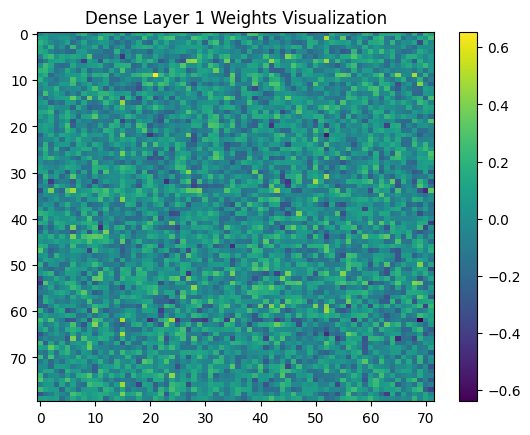

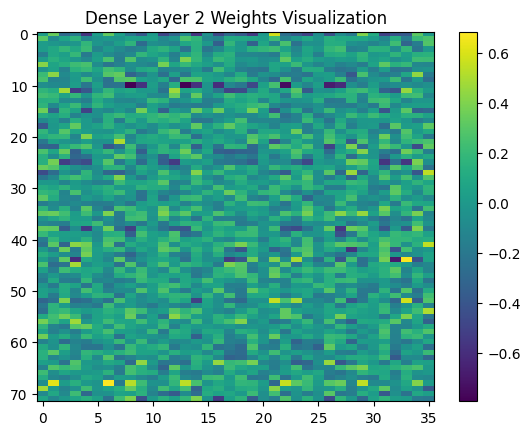

In [144]:
# Get the weights of all dense layers in the model
dense_weights = []
for layer in model.layers:
    if isinstance(layer, tf.keras.layers.Dense):
        weights = layer.get_weights()
        if len(weights) > 0:
            dense_weights.append(weights[0])

# Visualize the weights of each dense layer
for i, weights in enumerate(dense_weights):
    plt.figure()
    plt.imshow(weights, cmap='viridis', aspect='auto')
    plt.colorbar()
    plt.title(f"Dense Layer {i+1} Weights Visualization")
    plt.show()
